# Experiment I: Relative confidence small to full

Compare the evolution of the confidence function for the small and the full graphs

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Prepare graphs

In [3]:
from hypotest.ontologies import molecular_subgraph, full_graph
from grontocrawler.graph import produce_graph
from hypotest.graph_mutation import normalize_hypothgraph

INFO:rdflib:RDFLib Version: 4.2.1


In [7]:
sub_onto = molecular_subgraph.g
full_onto = full_graph.g

In [6]:
sub_unnorm = produce_graph.produce_graph(sub_onto, options=['existential-arcs'])
full_unnorm = produce_graph.produce_graph(full_onto, options=['existential-arcs'])

In [11]:
sub_norm, _ = normalize_hypothgraph.normalize_hypothgraph(sub_unnorm)
full_norm, _ = normalize_hypothgraph.normalize_hypothgraph(full_unnorm)

In [12]:
set(sub_norm.nodes()).issubset(set(full_norm.nodes()))

True

In [13]:
set(sub_norm.edges()).issubset(set(full_norm.edges()))

True

### Statistics of graphs

Number of nodes and arcs

In [30]:
print('Subgraph: number of nodes {} and arcs {}'.format(len(sub_norm.nodes()), len(sub_norm.edges())))

Subgraph: number of nodes 15 and arcs 19


In [31]:
print('Fullgraph: number of nodes {} and arcs {}'.format(len(full_norm.nodes()), len(full_norm.edges())))

Fullgraph: number of nodes 30 and arcs 57


## Choose configuration

In [20]:
from hypotest.graph_generation import hypoth_conf

In [33]:
Hypoth_Conf = hypoth_conf.Hypoth_Conf

In [143]:
conf_source, conf_target = hypoth_conf.generate_max_endpoints(sub_norm)
print(conf_source, conf_target)

('http://plumdeq.xyz/ontologies/hypothesis/Synovial_inflammation', 'http://plumdeq.xyz/ontologies/hypothesis/Cartilage_degeneration')


### Statistics on the configuration

Number of paths

In [26]:
import networkx as nx

In [144]:
nb_sub = len(list(nx.all_simple_paths(sub_norm, conf_source, conf_target)))
print('Number of paths in the subgraph is {}'.format(nb_sub))

Number of paths in the subgraph is 6


In [145]:
nb_full = len(list(nx.all_simple_paths(full_norm, conf_source, conf_target)))
print('Number of paths in the full graph is {}'.format(nb_full))

Number of paths in the full graph is 24


In [146]:
conf = Hypoth_Conf(conf_source, conf_target, [])

In [52]:
from hypotest.graph_generation import boundary

In [147]:
nb_sub_interior = len(list(boundary.in_boundary_interior(sub_norm, conf_source, conf_target)))
print('Number of nodes in the interior of the subgraph is {}'.format(nb_sub_interior))

Number of nodes in the interior of the subgraph is 9


In [148]:
nb_full_interior = len(list(boundary.in_boundary_interior(full_norm, conf_source, conf_target)))
print('Number of nodes in the interior of the full graph is {}'.format(nb_full_interior))

Number of nodes in the interior of the full graph is 12


## Draw this configuration

In [15]:
import os, sys
path_to_images = '../images/results-paper/exp1-rel-conf/'

In [17]:
relative_graphs = os.path.abspath(os.path.join(path_to_images, 'relative-graphs.dot'))
relative_graphs

'/Users/asan/code/projects/kr/hypotest/lib/conf_propagation/notebooks/images/results-paper/exp1-rel-conf/relative-graphs.dot'

In [18]:
from hypotest.io import write_dot

In [60]:
with open(relative_graphs, 'w') as f:
    write_dot.big_small_to_dot(full_norm, sub_norm, conf, f)

In [61]:
relative_graphs_png = os.path.abspath(os.path.join(path_to_images, 'relative-graphs.png'))
relative_graphs_png

'/Users/asan/code/projects/kr/hypotest/lib/conf_propagation/notebooks/images/results-paper/exp1-rel-conf/relative-graphs.png'

In [62]:
!dot -Tpng -o $relative_graphs_png $relative_graphs

In [63]:
from IPython.display import Image

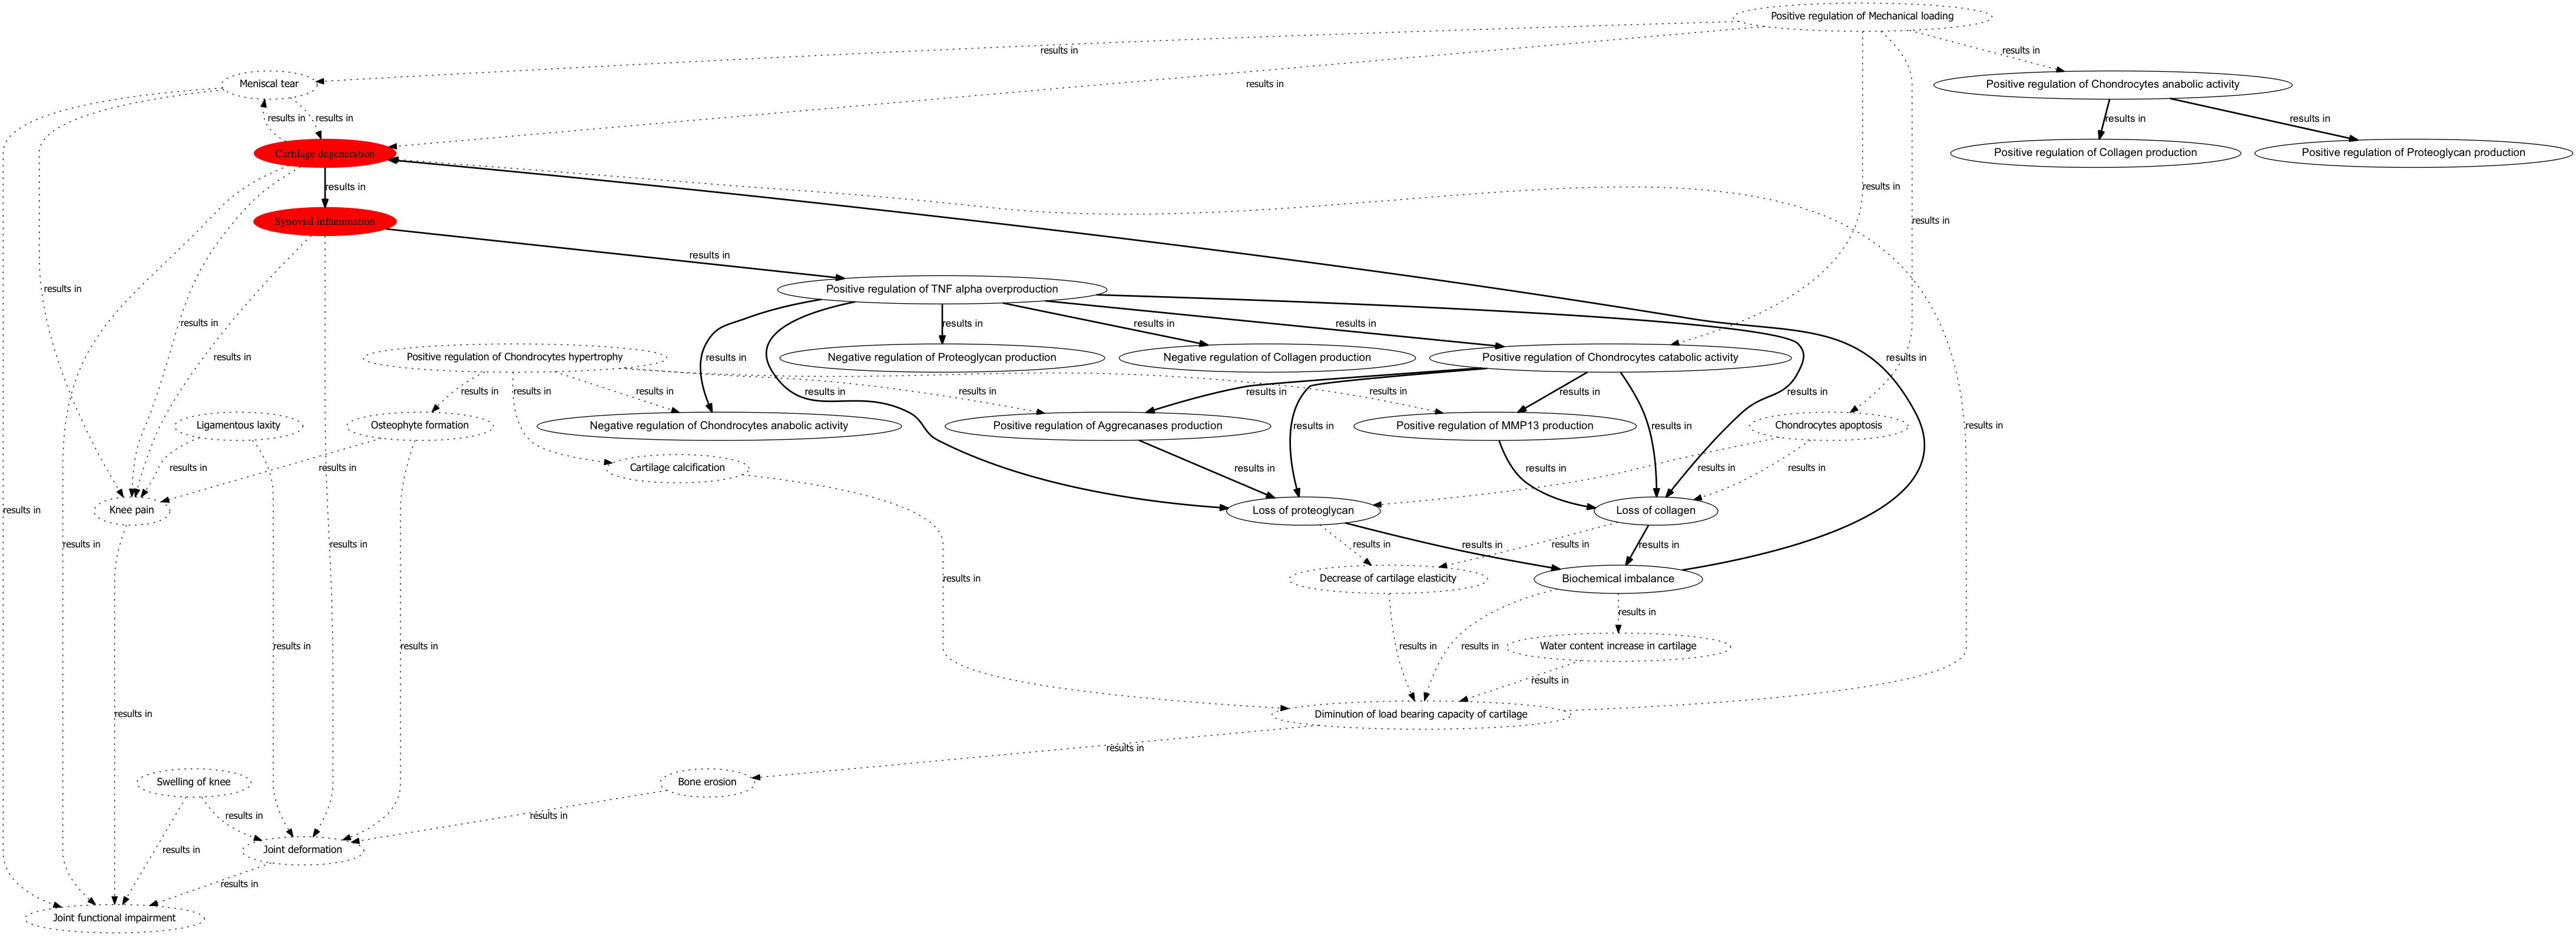

In [64]:
Image(relative_graphs_png)

## Compute confidences

We assume trivial weighting scheme for the factors

In [65]:
from hypotest.stats import confidences

In [219]:
sub_unnormalized_confidences = confidences.confidence_spectrum(sub_norm, conf_source, conf_target, normalized=False)
sub_normalized_confidences = confidences.confidence_spectrum(sub_norm, conf_source, conf_target, normalized=True)

In [184]:
full_unnormalized_confidences = confidences.confidence_spectrum(full_norm, conf_source, conf_target, normalized=False)
full_normalized_confidences = confidences.confidence_spectrum(full_norm, conf_source, conf_target, normalized=True)

In [157]:
max_full = max(full_unnormalized_conidences)
max_full

[168.0]

In [161]:
sub_norm_to_full_confidences = [np.array(x)/max_full for x in sub_unnormalized_confidences]

## Plot confidences

In [133]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [112]:
from matplotlib import pyplot as plt

Path for the figure, so that we can save in SVG or any other format

In [308]:
# When we plot confidences we need to take into account 'bigger' and 
# 'smaller' 
# graphs, i.e., the sizes of the confidence vectors might not be the same
def plot_confidences(bigger, smaller, bigger_label=None, 
                     smaller_label=None, 
                     legend_loc='upper left',
                     xlabel="",
                     ylabel=""):
    # Determine xs
    x_s = range(len(smaller))
    x_b = range(len(bigger))
    
    min_x = min(x_b)
    max_x = max(x_b)
    # min max of ys, they are list of lists
    min_y = np.min(bigger)[0]
    max_y = np.max(bigger)[0]
    
    # figure where you draw everything
    fig, ax = plt.subplots(nrows=1, ncols=1)
    
    # offsets for the plots
    offset_x = max(x_b) * 0.05
    offset_y = max_y * 0.05

    ax.set_xlim(min_x - offset_x, max_x + offset_x)
    ax.set_ylim(min_y - offset_y, max_y + offset_y)
    
    # Draw distributions
    ax.violinplot(smaller, x_s)
    ax.violinplot(bigger, x_b)
    
    # Compute the means
    smaller_means = [np.mean(x) for x in smaller]
    bigger_means = [np.mean(x) for x in bigger]
    
    # Draw the mean line
    ax.plot(smaller_means, 'o--', markersize=3.0, label=smaller_label)
    ax.plot(bigger_means, 'o--', markersize=3.0, label=bigger_label)
    
    # Annotations
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel, fontsize=16)
    
    ax.legend(fontsize=10.0, loc=legend_loc)
    
    return fig, ax

(<matplotlib.figure.Figure at 0x11444eed0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x114549f10>)

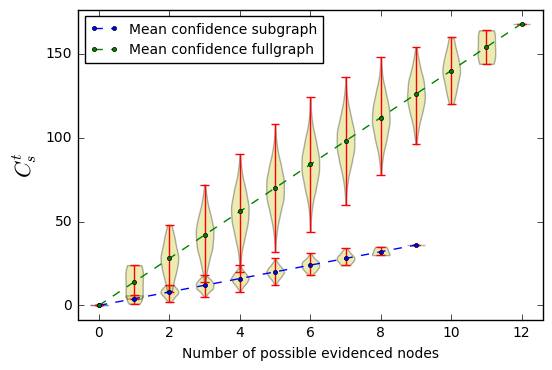

In [316]:
plot_confidences(full_unnormalized_confidences, 
                 sub_unnormalized_confidences,
                 smaller_label='Mean confidence subgraph',
                 bigger_label='Mean confidence fullgraph',
                 xlabel='Number of possible evidenced nodes',
                 ylabel=r'$C_s^t$')

(<matplotlib.figure.Figure at 0x115e49e10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1160776d0>)

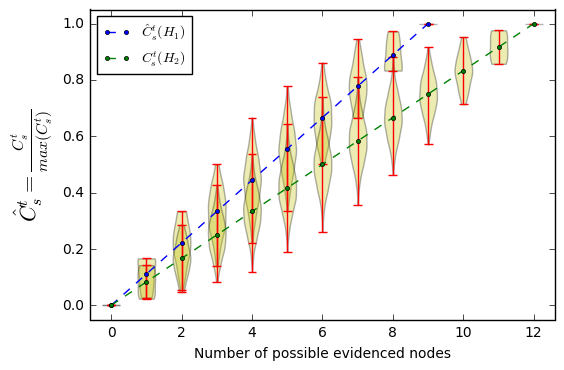

In [330]:
plot_confidences(full_normalized_confidences, 
                 sub_normalized_confidences,
                 smaller_label=r"$\hat{C}_s^t(H_1)$",
                 bigger_label="$C_s^t(H_2)$",
                 xlabel="Number of possible evidenced nodes",
                 ylabel=r"$\hat{C}_s^t = \frac{C_s^t}{max(C_s^t)}$")

In [340]:
max_full_unnorm = np.max(full_unnormalized_confidences)[0]
sub_norm_to_big = [np.array(x)/max_full_unnorm for x in sub_unnormalized_confidences]

In [342]:
max_full_unnorm

168.0

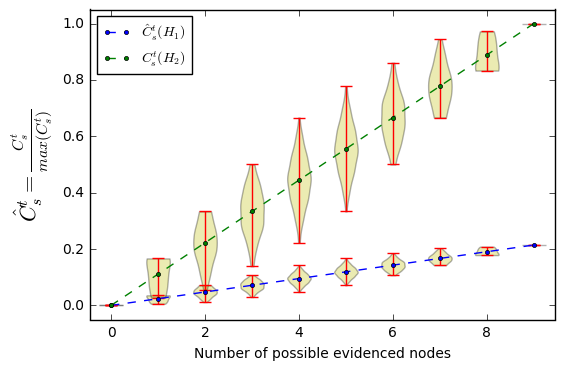

In [344]:
fig3, ax3 = plot_confidences(sub_normalized_confidences, 
                 sub_norm_to_big,
                 smaller_label=r"$\hat{C}_s^t(H_1)$",
                 bigger_label="$C_s^t(H_2)$",
                 xlabel="Number of possible evidenced nodes",
                 ylabel=r"$\hat{C}_s^t = \frac{C_s^t}{max(C_s^t)}$")

In [345]:
fig3_svg = os.path.abspath(os.path.join(path_to_images, 'subg_to_norm.svg'))
fig3.savefig(fig3_svg)